## Textual Inversion Inferencing

In [1]:
!pip install -q --upgrade transformers diffusers ftfy

In [2]:
from huggingface_hub import notebook_login
from pathlib import Path
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

In [3]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from transformers import logging
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import numpy
from torchvision import transforms as tfms

# For video display:
from IPython.display import HTML
from base64 import b64encode

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

In [5]:
def gen_with_text_embeddings(text_embeddings, height=512, width=512, steps=50, gd=7.5, seed=2324, resize_factor=0.5):
    generator = torch.manual_seed(seed)   # Seed generator to create the inital latent noise
    batch_size = 1

    # Prep text 
    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(steps)

    # Prep latents
    latents = torch.randn(
      (batch_size, unet.in_channels, height // 8, width // 8),
      generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]

    # Loop
    with autocast("cuda"):
        for i, t in tqdm(enumerate(scheduler.timesteps)):
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            sigma = scheduler.sigmas[i]
            # Scale the latents (preconditioning):
            # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + gd * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
            latents = scheduler.step(noise_pred, t, latents).prev_sample

    # scale and decode the image latents with vae
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample

    # Display
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    im = pil_images[0]
    return im.resize(((int)(im.width * resize_factor), (int)(im.height * resize_factor)))

In [6]:
token_emb_layer = text_encoder.text_model.embeddings.token_embedding
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding

In [7]:
pos_ids = text_encoder.text_model.embeddings.position_ids
pos_embs = pos_emb_layer(pos_ids)

In [9]:
# Let's define a function to get transformed embeddings
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True 
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

In [10]:
def make_embeddings(prompt):
    token_info = tokenizer(prompt, truncation=True, padding="max_length", return_tensors="pt")
    with torch.no_grad():
        text_embeddings = text_encoder(token_info.input_ids.to(torch_device))[0]
    return text_embeddings

In [85]:
import math
def __d(imgs, rows=1, resize_factor=1):
    w,h = imgs[0].size
    cols = math.ceil(len(imgs) / rows)
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid.resize(((int)(grid.size[0] * resize_factor), (int)(grid.size[1] * resize_factor)))

In [42]:
def find_token_id_by_word(word):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(word))[0]

def get_token_index(base_prompt, word):
    return torch.where(tokenizer(base_prompt, padding="max_length", return_tensors="pt").input_ids[0] == find_token_id_by_word(word))[0].item()

## Let's try a Base Prompt

In [33]:
prompt = "a picture of an beautiful indian actress with jewelery"

In [44]:
token_info = tokenizer(prompt, padding="max_length", return_tensors="pt").to(torch_device)
token_embs = token_emb_layer(token_info.input_ids)

0it [00:00, ?it/s]

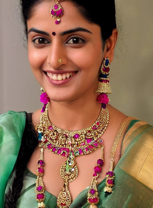

In [47]:
gen_with_text_embeddings(get_output_embeds(token_embs + pos_embs), height=700, seed=28, resize_factor=0.3)

## Let's loads a trained embedding

In [48]:
import torch

In [59]:
gta5_model = torch.load("./checkpoints/gta5.bin")
gta5_model?

Type:        dict
String form:
{'<gta5-artwork>': tensor([ 1.5327e-01, -1.4529e-03, -2.4478e-02,  1.4896e-01,  1.4151e-01,
           <...> 3139e-02,  8.7624e-02,  5.2024e-02,  2.5925e-01,
           1.7301e-02,  3.3638e-02, -1.1135e-01])}
Length:      1
Docstring:  
dict() -> new empty dictionary
dict(mapping) -> new dictionary initialized from a mapping object's
    (key, value) pairs
dict(iterable) -> new dictionary initialized as if via:
    d = {}
    for k, v in iterable:
        d[k] = v
dict(**kwargs) -> new dictionary initialized with the name=value pairs
    in the keyword argument list.  For example:  dict(one=1, two=2)


In [62]:
gta5_embs = gta5_model['<gta5-artwork>']
gta5_embs.shape

torch.Size([768])

In [68]:
new_prompt = "a picture of an beautiful indian actress with jewelery as gta"

In [69]:
token_info = tokenizer(new_prompt, padding="max_length", return_tensors="pt").to(torch_device)
token_embs = token_emb_layer(token_info.input_ids)

In [78]:
token_embs[0][get_token_index(new_prompt, "gta")] = gta5_embs

0it [00:00, ?it/s]

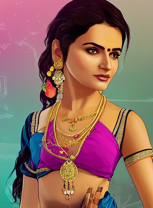

In [79]:
gen_with_text_embeddings(get_output_embeds(token_embs + pos_embs), height=700, seed=28, resize_factor=0.3)

In [92]:
# Let's make a reusable function
def replace_embs(prompt, keyword, new_embs):
    token_info = tokenizer(prompt, padding="max_length", return_tensors="pt").to(torch_device)
    token_embs = token_emb_layer(token_info.input_ids)
    token_embs[0][get_token_index(new_prompt, keyword)] = new_embs
    
    return token_embs

In [102]:
# Let's try some seeds
image_list = []
for rand_value in torch.rand(5):
    seed = (rand_value.item() * 99999) // 1
    new_token_embs = replace_embs(new_prompt, "gta", gta5_embs)
    im_gen = gen_with_text_embeddings(get_output_embeds(new_token_embs + pos_embs), height=700, seed=seed, resize_factor=0.3)
    image_list.append(im_gen)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

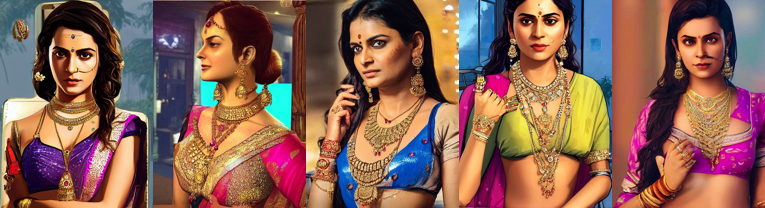

In [103]:
__d(image_list)

## Let's try another embedding

In [105]:
kuvshinov_model = torch.load("./checkpoints/kuvshinov.bin")
kuvshinov_embs = kuvshinov_model['<kuvshinov>']

In [107]:
image_list = []
for rand_value in torch.rand(5):
    seed = (rand_value.item() * 99999) // 1
    new_token_embs = replace_embs(new_prompt, "gta", kuvshinov_embs)
    im_gen = gen_with_text_embeddings(get_output_embeds(new_token_embs + pos_embs), height=700, seed=seed, resize_factor=0.3)
    image_list.append(im_gen)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

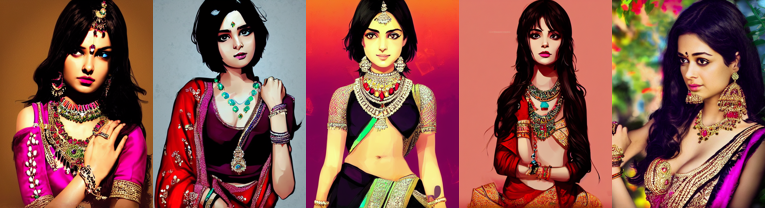

In [108]:
__d(image_list)

## Another One

In [111]:
moebius_model = torch.load("./checkpoints/moebius.bin")
moebius_embs = moebius_model['<moebius>']

In [112]:
image_list = []
for rand_value in torch.rand(5):
    seed = (rand_value.item() * 99999) // 1
    new_token_embs = replace_embs(new_prompt, "gta", moebius_embs)
    im_gen = gen_with_text_embeddings(get_output_embeds(new_token_embs + pos_embs), height=700, seed=seed, resize_factor=0.3)
    image_list.append(im_gen)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

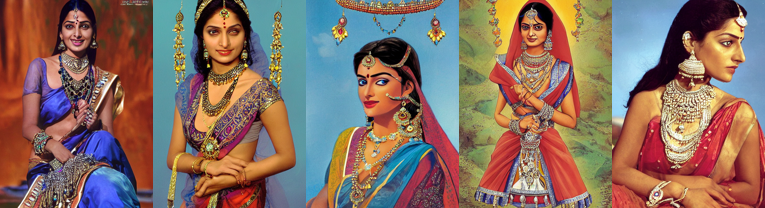

In [113]:
__d(image_list)